Dataset Overview:
Total Records: 50315
Unique Developments: 110
Unique Boroughs: 7

Missing Values:
Development Name       60
Borough                 0
Service Start Date      7
Service End Date        7
# days                  0
Estimated               0
Current Charges         0
Rate Class              0
Consumption (HCF)       0
Water&Sewer Charges     0
Service Duration        7
dtype: int64

Descriptive Statistics:
             # days  Current Charges  Consumption (HCF)  Water&Sewer Charges
count  50315.000000     50315.000000       50315.000000         50315.000000
mean      33.182953      2150.221066         224.291066          2140.327436
std       53.178140      5623.852543        2020.962056          5619.812518
min     -335.000000     -1748.510000           0.000000             0.000000
25%       29.000000        46.460000           5.000000            46.360000
50%       30.000000       197.360000          26.000000           196.350000
75%       32.000000      2598.415000 

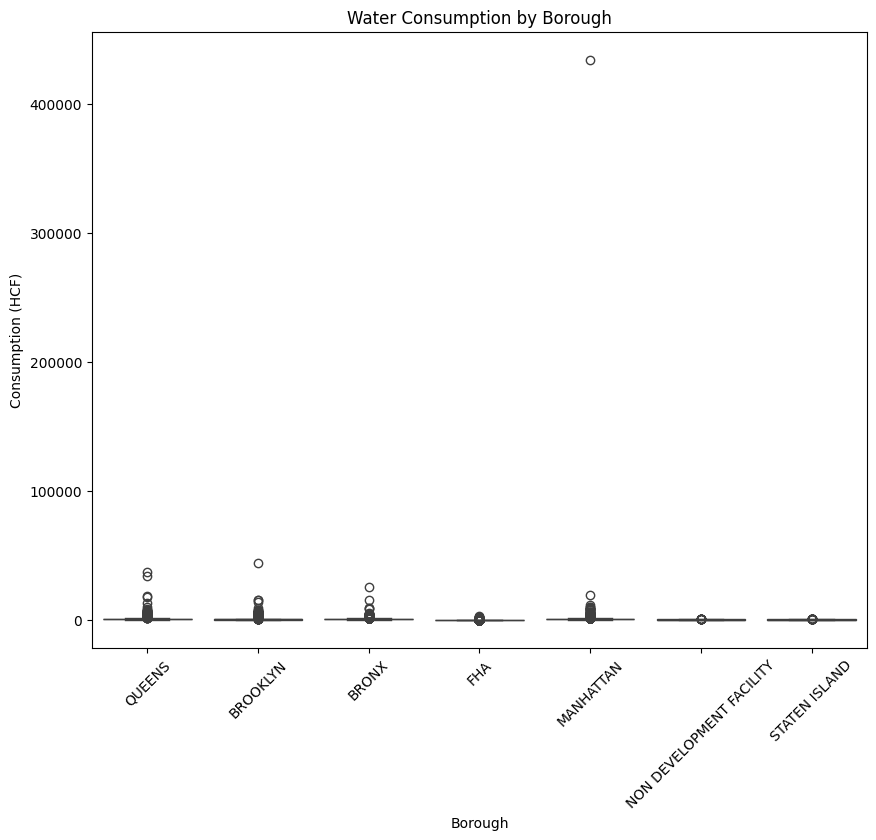

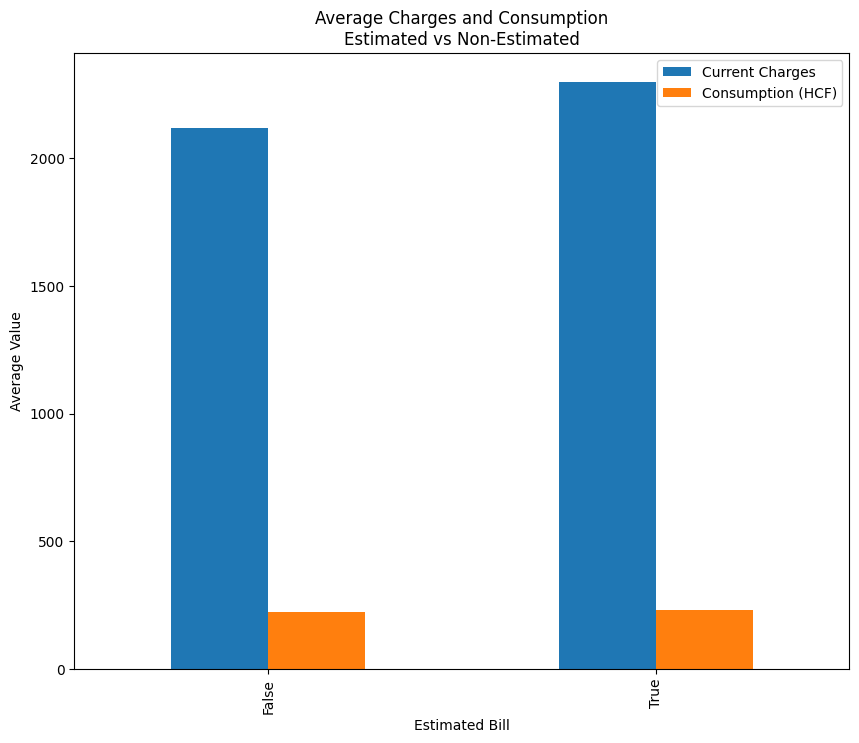

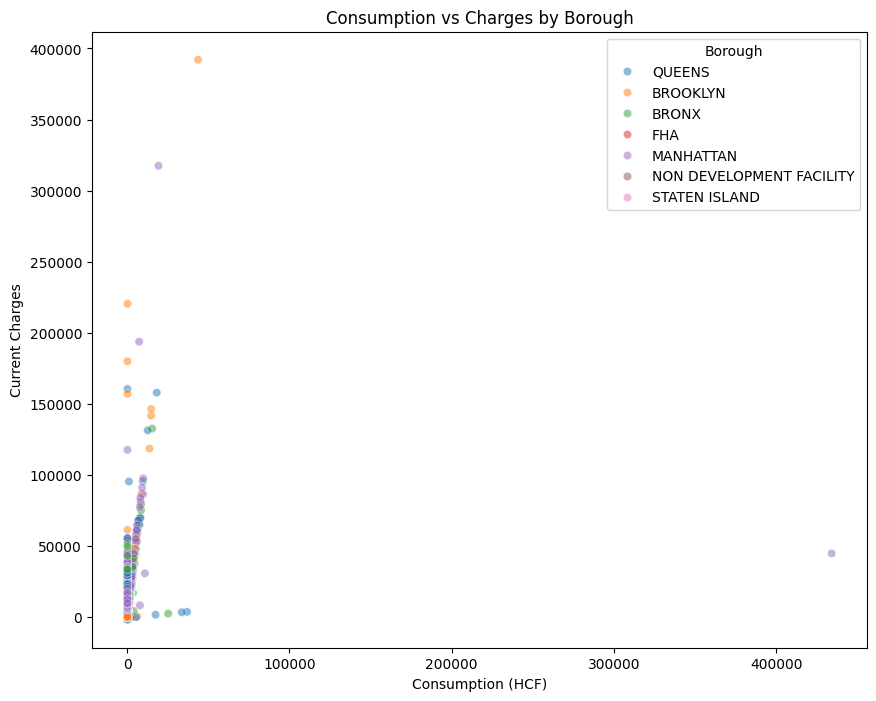

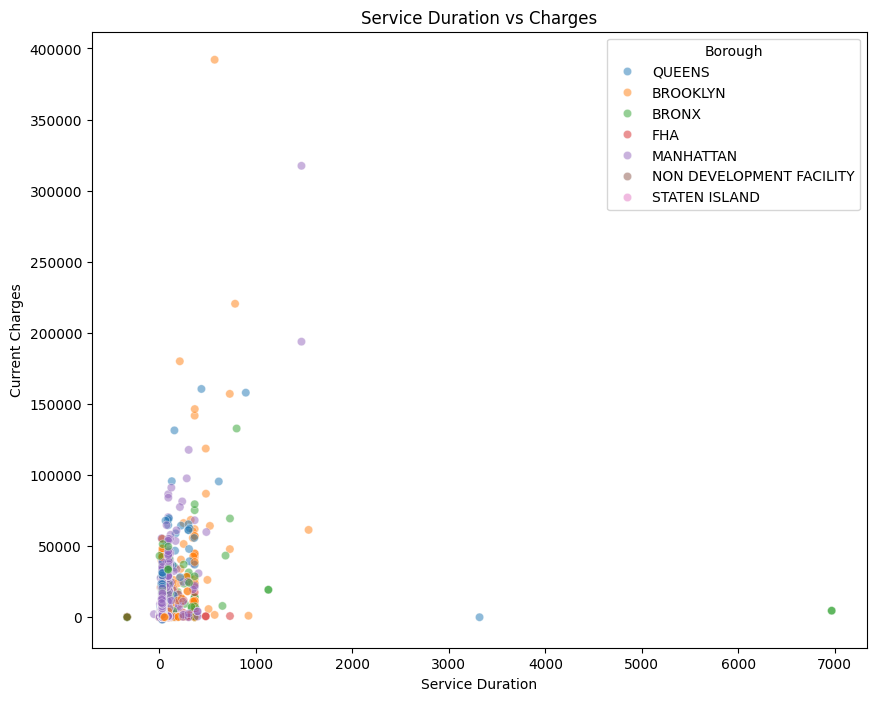

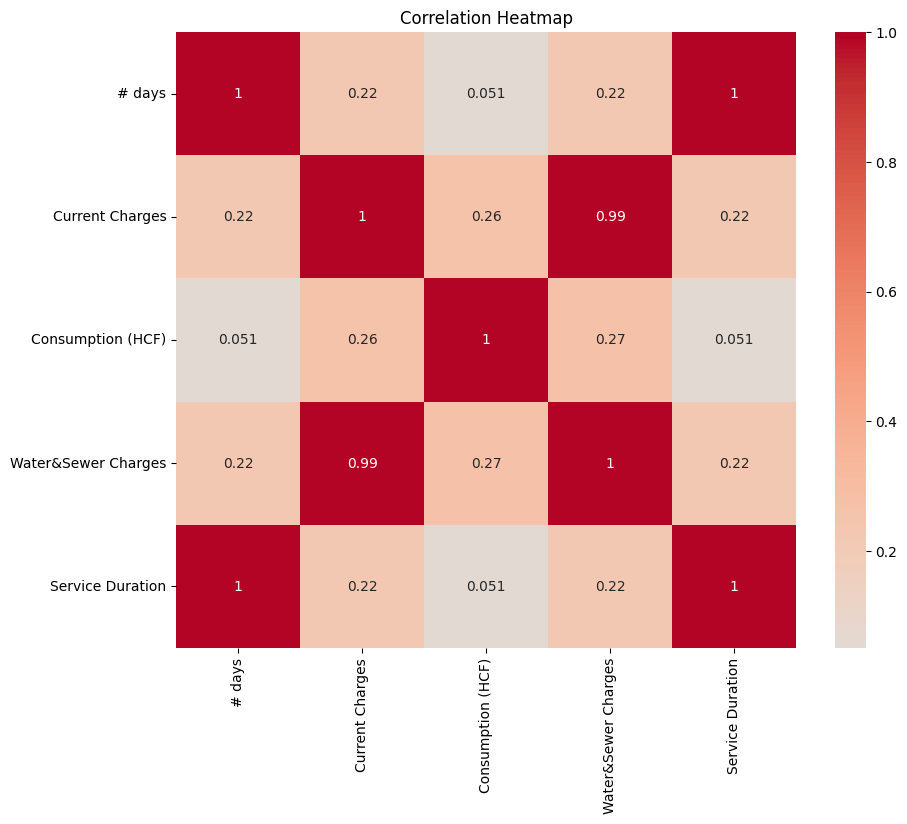


Borough-wise Analysis:
                         Current Charges              Consumption (HCF)  \
                                    mean          sum              mean   
Borough                                                                   
BRONX                        4175.411290  20492918.61        406.366748   
BROOKLYN                     2887.050494  26191322.08        286.216931   
FHA                           110.412750   2590283.11         23.675703   
MANHATTAN                    4148.043460  34047140.72        439.024732   
NON DEVELOPMENT FACILITY      140.158333      8409.50         55.016667   
QUEENS                       5547.361120  24818893.65        564.470720   
STATEN ISLAND                 296.280226     39405.27         48.924812   

                                  Development Name  
                              sum          nunique  
Borough                                             
BRONX                     1994448               28  
BROOKLYN     

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings("ignore")

# Load and Preprocess Data
file_path = r"C:\Users\billj\Downloads\smart-city-water-metering-and-governance\Dataset\Water_Consumption_And_Cost__2013_-_Feb_2023_.csv"
columns_needed = [
    "Development Name", "Borough", "Service Start Date", "Service End Date", "# days",
    "Estimated", "Current Charges", "Rate Class", "Consumption (HCF)", "Water&Sewer Charges"
]

df = pd.read_csv(file_path, usecols=columns_needed)

# Preprocessing
def preprocess_data(df):
    # Convert numerical columns
    numeric_columns = ["# days", "Current Charges", "Consumption (HCF)", "Water&Sewer Charges"]
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Convert dates
    df["Service Start Date"] = pd.to_datetime(df["Service Start Date"], errors='coerce')
    df["Service End Date"] = pd.to_datetime(df["Service End Date"], errors='coerce')
    
    # Calculate service duration
    df["Service Duration"] = (df["Service End Date"] - df["Service Start Date"]).dt.days
    
    # Convert Estimated to boolean
    df["Estimated"] = df["Estimated"].map({"Y": True, "N": False})
    
    # Fill missing values in numeric columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    # Fill missing values in categorical columns
    df["Borough"].fillna(df["Borough"].mode()[0], inplace=True)
    df["Rate Class"].fillna(df["Rate Class"].mode()[0], inplace=True)
    
    return df

df = preprocess_data(df)

# Comprehensive EDA Function
def perform_comprehensive_eda(df):
    # 1. Basic Dataset Information
    print("Dataset Overview:")
    print(f"Total Records: {len(df)}")
    print(f"Unique Developments: {df['Development Name'].nunique()}")
    print(f"Unique Boroughs: {df['Borough'].nunique()}")
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # 2. Descriptive Statistics
    print("\nDescriptive Statistics:")
    desc_stats = df[["# days", "Current Charges", "Consumption (HCF)", "Water&Sewer Charges"]].describe()
    print(desc_stats)
    
    # 3. Visualizations
    
    # Consumption by Borough
    plt.figure(figsize=(10, 8))
    sns.boxplot(x="Borough", y="Consumption (HCF)", data=df)
    plt.title("Water Consumption by Borough")
    plt.xticks(rotation=45)
    plt.show()
    
    # Estimated vs Non-Estimated Bills
    plt.figure(figsize=(10, 8))
    estimated_compare = df.groupby("Estimated")[["Current Charges", "Consumption (HCF)"]].mean()
    estimated_compare.plot(kind="bar", ax=plt.gca())
    plt.title("Average Charges and Consumption\nEstimated vs Non-Estimated")
    plt.xlabel("Estimated Bill")
    plt.ylabel("Average Value")
    plt.legend(loc='best')
    plt.show()
    
    # Consumption vs Charges Scatter
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x="Consumption (HCF)", y="Current Charges", hue="Borough", data=df, alpha=0.5)
    plt.title("Consumption vs Charges by Borough")
    plt.show()
    
    # Service Duration Impact
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x="Service Duration", y="Current Charges", hue="Borough", data=df, alpha=0.5)
    plt.title("Service Duration vs Charges")
    plt.show()
    
    # 4. Correlation Analysis
    correlation_matrix = df[["# days", "Current Charges", "Consumption (HCF)", "Water&Sewer Charges", "Service Duration"]].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap")
    plt.show()
    
    # 5. Borough-wise Analysis
    borough_analysis = df.groupby("Borough").agg({
        "Current Charges": ["mean", "sum"],
        "Consumption (HCF)": ["mean", "sum"],
        "Development Name": "nunique"
    })
    print("\nBorough-wise Analysis:")
    print(borough_analysis)
    
    # 6. Rate Class Analysis
    rate_class_analysis = df.groupby("Rate Class").agg({
        "Current Charges": ["mean", "sum"],
        "Consumption (HCF)": ["mean", "sum"]
    })
    print("\nRate Class Analysis:")
    print(rate_class_analysis)

# Model Training Functions
def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_decision_tree(X_train, y_train, max_depth=None):
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_gradient_boosting(X_train, y_train, n_estimators=100):
    model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    return model

# Model Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared Score: {r2:.4f}")
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Feature Selection and Preparation
def prepare_features_and_target(df, target_column):
    # Drop the target column from features
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Handle categorical columns (Borough, Development Name, Rate Class)
    categorical_cols = ["Borough", "Development Name", "Rate Class"]
    
    # Column transformer with one hot encoding for categorical variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), ['# days', 'Consumption (HCF)', 'Water&Sewer Charges', 'Service Duration']),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ]
    )
    
    # Apply the transformations
    X_processed = preprocessor.fit_transform(X)
    
    return X_processed, y

# Model Comparison Function
def main_model_comparison(file_path, target_column='Current Charges'):
    # Load and preprocess data
    df = pd.read_csv(file_path, usecols=[ 
        "Development Name", "Borough", "Service Start Date", "Service End Date", "# days",
        "Estimated", "Current Charges", "Rate Class", "Consumption (HCF)", "Water&Sewer Charges"
    ])
    df = preprocess_data(df)  # Preprocess the loaded data
    
    # Prepare features and target
    X, y = prepare_features_and_target(df, target_column)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler(with_mean=False)  # Use with_mean=False to avoid centering sparse matrices
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to train
    models = {
        'Linear Regression': (train_linear_regression, {}),
        'Decision Tree': (train_decision_tree, {'max_depth': 10}),
        'Random Forest': (train_random_forest, {'n_estimators': 100}),
        'Gradient Boosting': (train_gradient_boosting, {'n_estimators': 100}),
    }
    
    # Store model performance
    model_performances = {}
    
    # Train and evaluate models
    for model_name, (train_func, params) in models.items():
        print(f"\nTraining {model_name}...")
        
        # Train the model
        model = train_func(X_train_scaled, y_train, **params)
        
        # Predict on test set
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        model_performances[model_name] = evaluate_model(y_test, y_pred, model_name)
    
    return model_performances

# Run the comprehensive EDA and model comparison
perform_comprehensive_eda(df)
results = main_model_comparison(file_path)
